<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/socially_distanced_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Face Recognition

*eigenfaces*, *pca*

**Problem**

Given images of a person, we would like to recognize which subject it belongs to. 

We will use a subset of data from the famous Yale Face dataset. Data is contained in `yalefaces` folder, with tif images of two subjects. 

**Method**

We perform downsampling of the image by a factor of 4 to turn them into a lower resolution image as a preprocessing (e.g., reduce a picture of size 16-by-16 to 4-by-4). 

One strategy is via eigenfaces from PCA. First, given a set of images for each person, we generate the eigenface using these images. We first vectorize each image, which was originally given as a matrix. We treat one picture from the same person as one data point for that person. Thus, the data matrix for each person is a matrix with each row being a vectorized picture. Then, we apply PCA to each person's data matrix to find their first few principal components. 



**References**

* Credits to Dr. Yao Xie for designing this problem.

## Implementation

In [4]:
import os
import numpy as np
from os.path import abspath, exists
from scipy import sparse
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import scipy.sparse.linalg as ll
import collections
from scipy.io import loadmat
from sklearn.metrics import pairwise_distances
import sklearn.preprocessing as skpp
import math

In [14]:
def computeISOMAP(data, K, epsilon = 501, distType = "euclidean"):
    # compute similarity matrix
    A = pairwise_distances(data, metric=distType)
    np.savetxt("data/faces_adjacency_matrix.csv", A, delimiter=",")
    if not check_symmetric(A):
       return "Aborted. Adjacency matrix is not symmetric. Please check"

    # visualize the similarilty graph A (adjacency matrix)  698x698
    showMatrix(A, "Visualization of Adjacency Matrix")

    # tune epsilon
    nConnected = np.sum((A < epsilon).astype(np.int), axis=0)
    nGreater100 = np.sum((nConnected >= 100).astype(np.int), axis=0)
    print("Number of nodes with more than 100 edges is ", nGreater100)
    A = np.where(A < epsilon, A, 1000000) # set not connected edges to a large number
    
    # Compute pairwise shortest distance matrix D
    D = Matrix_D(A)  # comment out if choose to import previously ran csv file
    np.savetxt("data/Matrix_D.csv", D, delimiter=",")

    # Use a centering matrix H = I - 1/m 11^T to get C
    m = A.shape[0]
    H = np.identity(m) - np.ones((m, m)) / m
    C = - H * D * D * H / 2

    # Eigendecomposition on C and largest eigenvalues
    l, w = ll.eigs(C)        
    idx = l.argsort()[::-1][:K]     # k largest 
    l = l[idx].real
    w = w[:, idx].real

    # reduced representation
    Z = np.dot(w, np.diag(np.sqrt(l)))
    
    # Visualization
    description = 'ISOMAP 2D Representation of Faces using ' + distType + ' distance'
    show2DwithImages(Z, data, n = 20, title = description)

    return Z

In [15]:
def computePCA(data, K):  

    # preprocessing. Do not neet normalization because data have similar values!
    m, n = data.shape            # combining n features into k
    Anew = data.T

    # Eigendecomposition
    mu = np.mean(Anew, axis = 1)                         # n x 1
    xc = Anew - mu[:, None]
    C = np.dot(xc, xc.T)/m                            # covariance matrix, n x n
    l, w = ll.eigs(C)        
    idx = l.argsort()[::-1][:K]                       # k largest 
    l = l[idx].real
    w = w[:, idx].real

    # extract principal components 
    pc = np.empty([K, m])           
    for i in range(K):
        pc[i, :] = np.dot(w[:,i].T, xc)/math.sqrt(l[i])
    pc = pc.T
    
    show2DwithImages(pc, data, n = 20, title = 'PCA 2D Representation of Faces')

    return pc

In [16]:
# Utility functions
def show2DwithImages(vec, data, n = 20, title = 'ISOMAP 2D Representation of Faces'):
    m = vec.shape[0]
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot()
    ax.set_title(title)
    x_size = (max(vec[:, 0]) - min(vec[:, 0])) * 0.1
    y_size = (max(vec[:, 1]) - min(vec[:, 1])) * 0.1
    for i in range(n):
        idx = np.random.randint(0, m)
        x0, x1 = vec[idx, 0] - (x_size / 2.), vec[idx, 0] + (x_size / 2.)
        y0, y1 = vec[idx, 1] - (y_size / 2.), vec[idx, 1] + (y_size / 2.)
        image_1d = data[idx, :]
        image_2d = np.reshape(image_1d, (64, 64), 'C').T
        ax.imshow(image_2d, extent=(x0, x1, y0, y1), cmap='gray', interpolation='nearest', zorder=100)
        ax.scatter(vec[idx, 0], vec[idx, 1], s=80, facecolors='none', edgecolors='r')
    plt.scatter(vec[:, 0], vec[:, 1], alpha = 0.8)
    plt.show()

def showImage(image_1d, title="", footnote=""):
    image_2d = np.reshape(image_1d, (64, 64), 'C').T
    plt.imshow(image_2d)
    plt.title(title, fontdict=None, loc='center', pad=None)
    plt.xlabel(footnote)
    plt.show()

def showMatrix(data, title):
    plt.imshow(data)
    plt.colorbar()
    plt.title(title)
    plt.show()
    print("done")

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

## Results

In [11]:
data = loadmat('data/isomap.mat')  # 4096 x 698
data = data['images'].T            # 698 x 4096

First, we shown that PCA do not produce nice results for this case.

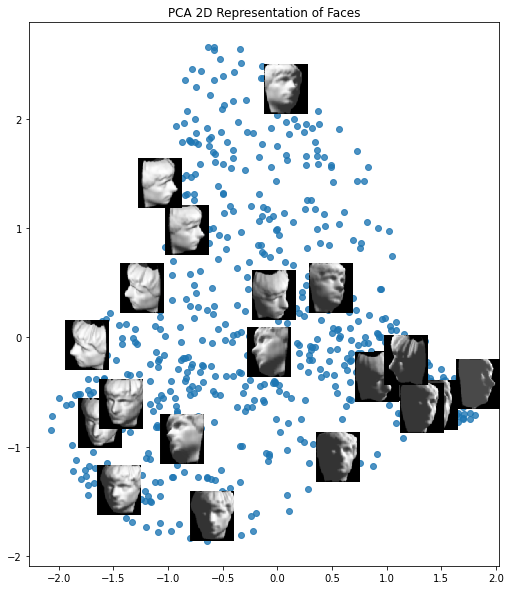

In [19]:
pc = computePCA(data, 2)

Below are results using ISOMAP with two different distance measures.

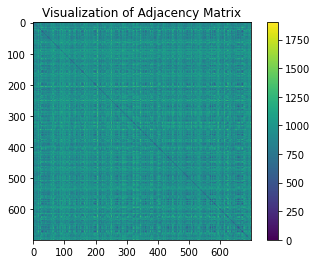

done
Number of nodes with more than 100 edges is  698


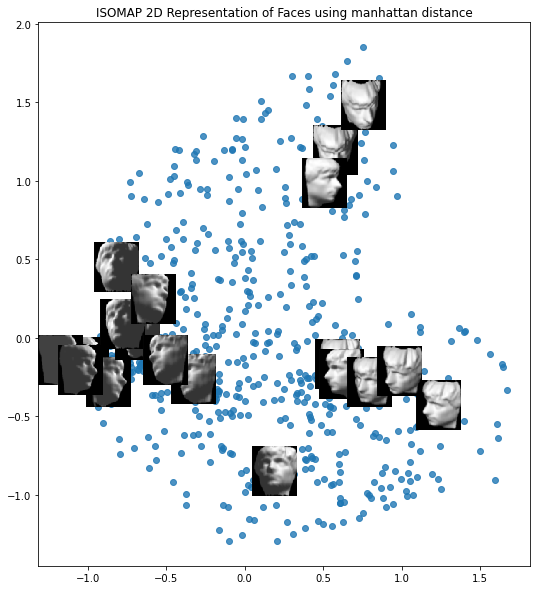

array([[ 0.20629544, -0.28944759],
       [-0.47407367, -0.2701809 ],
       [ 0.39720533, -0.25543827],
       ...,
       [-1.09783861, -0.19359203],
       [-0.30646708,  1.19015332],
       [-0.70617279,  0.27495557]])

In [17]:
computeISOMAP(data, 2, epsilon = 1010, distType = "manhattan")

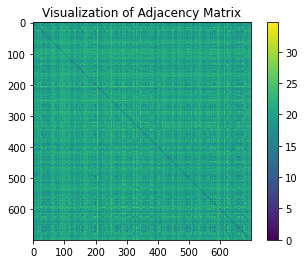

done
Number of nodes with more than 100 edges is  698


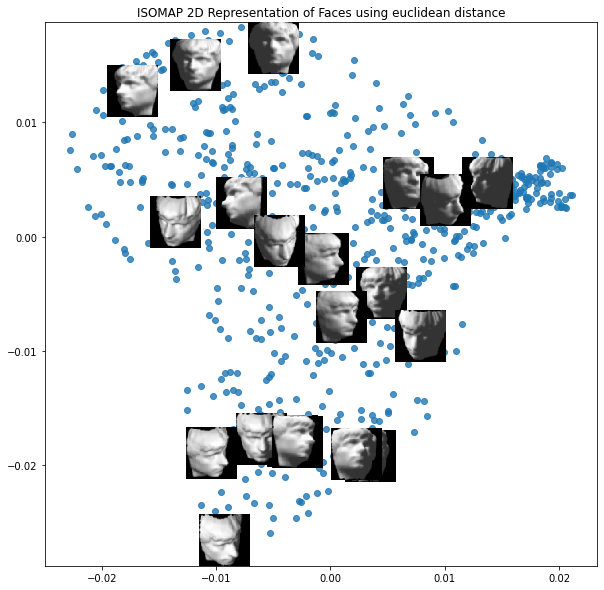

array([[-0.0047009 ,  0.00466747],
       [ 0.0059608 ,  0.00363831],
       [-0.00753413,  0.004478  ],
       ...,
       [ 0.01930791,  0.00371577],
       [ 0.00226182, -0.01903499],
       [ 0.01089401, -0.0043174 ]])

In [18]:
computeISOMAP(data, 2, epsilon = 501, distType = "euclidean")

The graph shows the 2D representation and the original images of randomly
chosen 20 images. We can see that ISOMAP was able to organize the faces based on angles or order. The
images facing to the right are on the right side of the x-axis, the images heading down are are on the bottom
of the y-axis, vice verse. The results show similar patterns to the results of the original paper.